In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import arviz as az
import pymc as pm
import pymc.sampling_jax
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
mu = 175
sigma = 7
n = 30
n_samples = 1000

samples = np.stack([np.random.normal(loc=mu, scale=sigma, size=n) for i in range(n_samples)])
samples.shape

(1000, 30)

In [4]:
print(*samples[1, :])

173.05987955215173 172.77780593771305 177.89064880253977 171.53156199723648 173.8328686116412 172.24629519939475 167.68049103688148 182.6999538365376 166.1380738352221 169.10438445235056 181.94548069772245 168.11150918671248 168.25220771988307 166.141339941861 167.04473085338194 159.34184299964062 164.87127091196987 177.38553090661225 175.54113674732255 177.13358300777057 175.66120482494384 173.15034035186193 160.09324790824562 171.04582236262732 180.57397985288574 176.5580825061673 176.13873405179868 180.1701200652904 169.99565779637925 166.7396007687377


In [5]:
xbar = samples.mean(axis=1)
print(*xbar[0:10])

174.16012803596917 172.0952462241161 174.03086888606612 172.55852292861735 174.21615098106778 174.84361415358953 174.91419227153176 175.07918942077302 177.08477022800628 175.67500515618016


In [6]:
alpha = 0.05
t = st.t.ppf(1 - alpha/2, n-1)
t

2.045229642132703

In [7]:
interval_width = t * samples.std(axis=1, ddof=1) / np.sqrt(n)
CI_low = samples.mean(axis=1) - interval_width
CI_high = samples.mean(axis=1) + interval_width

In [8]:
coverage_p = np.sum(np.logical_and(CI_low < mu, mu < CI_high)) / samples.shape[0]
coverage_p

0.95

In [9]:
sample_size = 20
mu = 50
sigma = 10
sample_data = np.random.normal(loc=mu, scale=sigma, size=n)
print(sample_data)

[64.03947811 42.98426981 58.81571183 50.47148565 45.06419058 38.30789182
 25.40384666 49.94286794 47.14075305 69.04253813 62.12477383 51.77730101
 47.97294492 54.50000282 44.84682197 36.36663327 34.88916698 63.93024625
 59.87658248 55.03037912 54.84332541 43.04043884 46.81372039 60.19801351
 54.71296789 36.57460635 29.52460418 34.32702342 51.47547701 49.33629841]


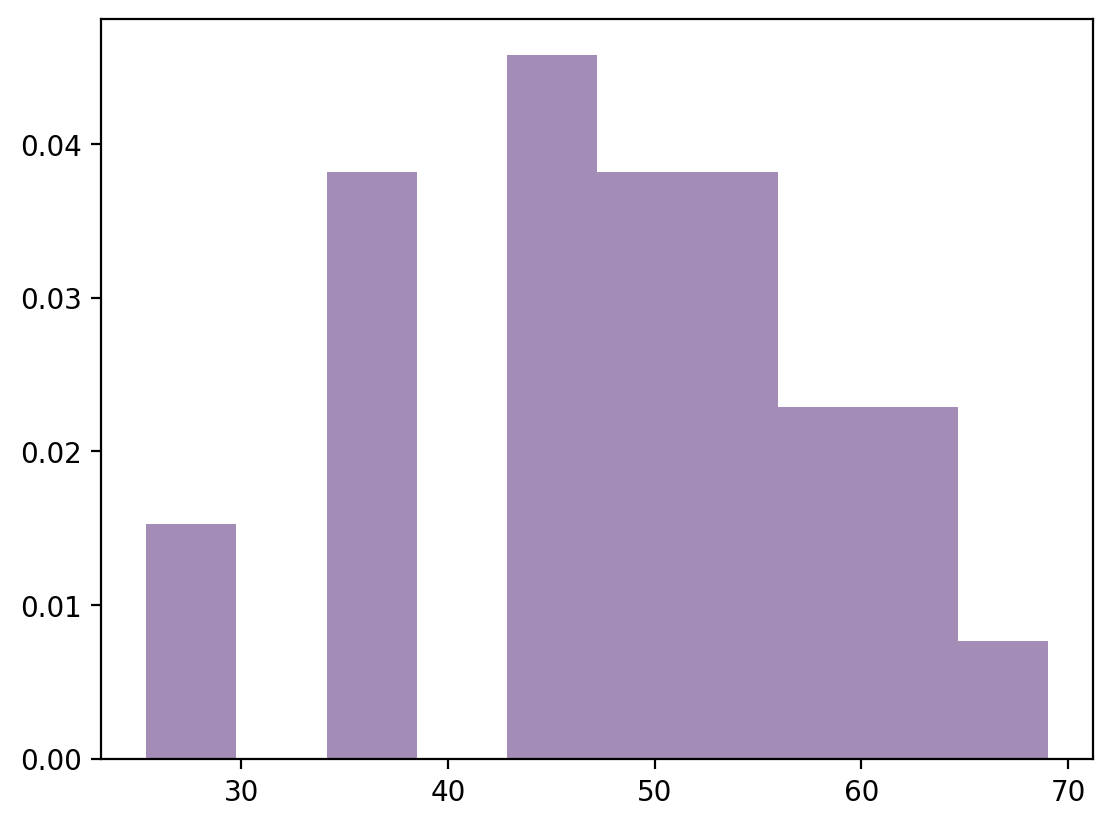

In [10]:
plt.hist(sample_data, density=True, alpha=0.5)
plt.show()

In [11]:
sample_mean = np.mean(sample_data)
sample_mean

48.779145388074554

In [12]:
sample_stddev = np.std(sample_data, ddof=1)
sample_stddev

10.835095506922961

In [13]:
standard_error = sample_stddev / np.sqrt(sample_size)
print(standard_error)

2.422801009618228


In [14]:
degrees_of_freedom = sample_size - 1
t_val = st.t.ppf(0.975, degrees_of_freedom)
print(t_val)

2.093024054408263


In [15]:
margin_of_error = t_val * standard_error
print(margin_of_error)

5.070980792175577


In [16]:
confidence_interval_lower = sample_mean - margin_of_error
confidence_interval_upper = sample_mean + margin_of_error
confidence_interval = [confidence_interval_lower, confidence_interval_upper]
print(confidence_interval)

[43.70816459589898, 53.85012618025013]


In [17]:
def visualize_output(sample_data, sample_mean, interval, type_interval):
    plt.hist(sample_data, density=True, alpha=0.5)
    plt.axvline(x=sample_mean, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(x=interval[0], color='g', linewidth=2)
    plt.axvline(x=interval[1], color='g', linewidth=2)
    plt.legend(['Sample Mean', f'{type_interval} interval'])

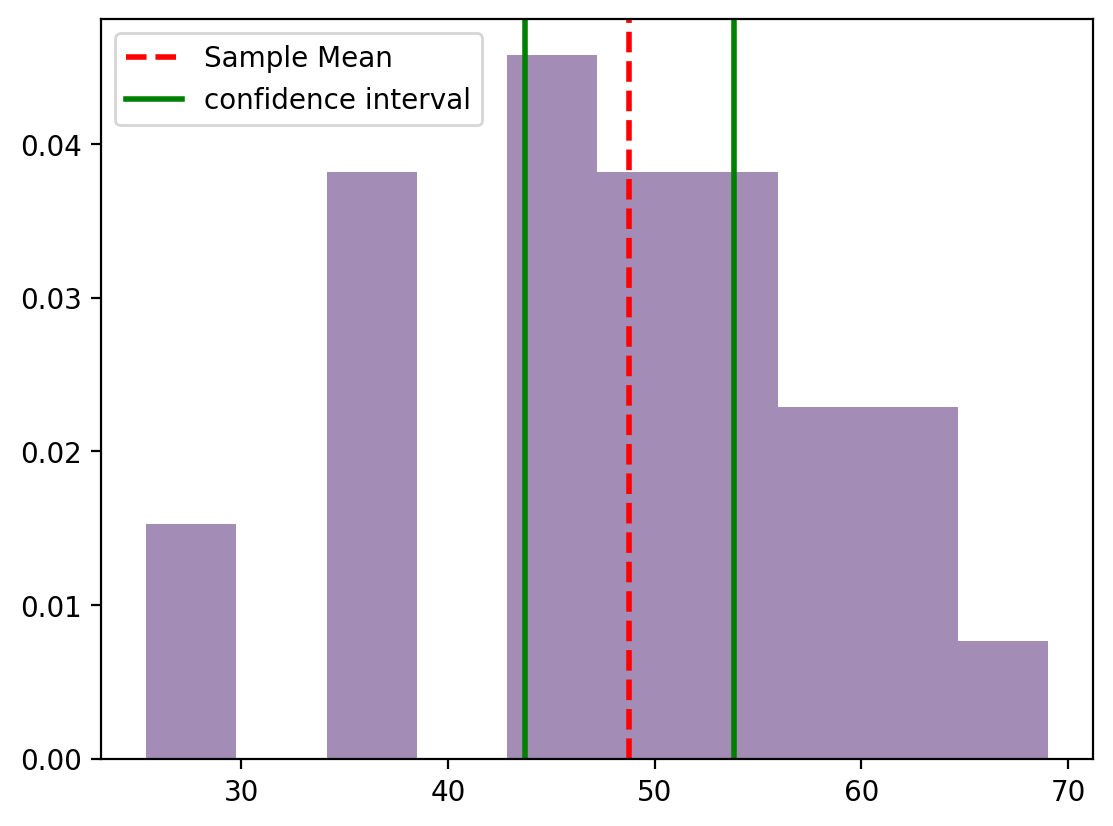

In [18]:
visualize_output(sample_data, sample_mean, confidence_interval, 'confidence')

In [19]:
model = pm.Model()

with model:
    mu = pm.Normal("mu", mu=sample_mean, sigma=20)
    sigma = pm.HalfNormal("sigma", 20)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=sample_data)

In [20]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:00.613378
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.483944
Transforming variables...
Transformation time =  0:00:00.015659


In [21]:
az.summary(idata, hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,48.79,2.09,44.66,52.73,0.04,0.03,2738.76,2563.21,1.0
sigma,11.27,1.54,8.39,14.28,0.03,0.02,2646.46,2131.43,1.0


In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pymc      : 5.6.1
numpy     : 1.25.2
scipy     : 1.10.1
matplotlib: 3.7.2
pandas    : 2.0.3
arviz     : 0.16.0

Watermark: 2.4.3

